Find the optimal number of hidden neurons for the first depth and widths of the neural network designed in Question 1 and 2.

#### Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. Continue using 5-fold cross validation on the training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. [optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.



This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [2]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

C:\Users\Admin\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [5]:

from common_utils import MLP, CustomDataset, EarlyStopper, preprocess_dataset

In [7]:
# Modified MLP class to vary depth of network
class FlexibleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=0.2))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=0.2))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [10]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    
    # Convert labels to float and reshape
    y_train2 = y_train2.float().unsqueeze(1)  # Shape: [N, 1]
    y_val2 = y_val2.float().unsqueeze(1)      # Shape: [N, 1]
    
    # Initialize datasets and dataloaders
    train_dataset = CustomDataset(X_train_scaled, y_train2)
    val_dataset = CustomDataset(X_val_scaled, y_val2)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    # Initialize lists to store metrics
    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    times = []
    
    num_epochs = 15  
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_scaled)
            val_loss = criterion(val_outputs, y_val2)
            val_predicted = (val_outputs >= 0.5).float()
            val_accuracy = (val_predicted == y_val2).sum().item() / len(y_val2)
        
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(total_loss / len(train_loader))
        test_accuracies.append(val_accuracy)
        test_losses.append(val_loss.item())
        times.append(time.time() - start_time)

        # with torch.no_grad():
        #     for X_batch, y_batch in val_loader:
        #         outputs = model(X_batch)
        #         loss = criterion(outputs, y_batch.unsqueeze(1))
        #         val_loss += loss.item()
        #         predicted = (outputs > 0.5).float()
        #         total_val += y_batch.size(0)
        #         correct_val += (predicted.squeeze() == y_batch).sum().item()
        
        # # Calculate and store metrics
        # train_acc = correct_train / total_train
        # val_acc = correct_val / total_val
        # train_accuracies.append(train_acc)
        # test_accuracies.append(val_acc)
        # train_losses.append(train_loss / len(train_loader))
        # test_losses.append(val_loss / len(val_loader))
        # times.append(time.time() - start_time)
    
    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [12]:
def generate_cv_folds(parameters, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Scale the features
        X_train_scaled, X_val_scaled = preprocess_dataset(X_train_fold, X_val_fold)
        
        # Convert to PyTorch tensors
        # X_train_scaled_dict[fold].append(X_train_scaled)
        # X_val_scaled_dict[fold].append(X_val_scaled)
        # y_train_dict[fold].append(y_train_fold)
        # y_val_dict[fold].append(y_val_fold)
        X_train_scaled_dict[fold] = torch.FloatTensor(X_train_scaled)
        X_val_scaled_dict[fold] = torch.FloatTensor(X_val_scaled)
        y_train_dict[fold] = torch.FloatTensor(y_train_fold)
        y_val_dict[fold] = torch.FloatTensor(y_val_fold)
    
    return X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict

In [14]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    
    cross_validation_accuracies = []
    cross_validation_times = []
    
    X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict = generate_cv_folds(parameters, X_train, y_train)
    
    for architecture in tqdm.tqdm(architectures):
        fold_accuracies = []
        fold_times = []
        
        for fold in range(5):

            model = FlexibleMLP(input_size=X_train.shape[1], 
                               hidden_sizes=architecture, 
                               output_size=1)  # Binary classification, so output_size=1
    
            train_accuracies, _, test_accuracies, _, times = train(
                model,
                X_train_scaled_dict[fold],
                y_train_dict[fold],
                X_val_scaled_dict[fold],
                y_val_dict[fold],
                batch_size
            )
            
            fold_accuracies.append(test_accuracies[-1]) # appending last epoch accuracy for every fold
            fold_times.append(times[-1]) # appending last epoch time for every fold
        
        cross_validation_accuracies.append(np.mean(fold_accuracies))
        cross_validation_times.append(np.mean(fold_times))
    
    return cross_validation_accuracies, cross_validation_times


In [16]:
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()


# Remove 'filename' and 'label' columns from features
X_train = df.drop(['filename', 'label'], axis=1)
y_train = preprocessing.LabelEncoder().fit_transform(df['label'])

In [38]:

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
optimal_bs = 64

architectures = [
    [64], [128], [256],           # 1 layer
    [64, 64], [128, 128], [256, 256],     # 2 layers
    [64, 64, 64], [128, 128, 128], [256, 256, 256]  # 3 layers
]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, architectures, 'num_neurons', optimal_bs)

100%|██████████| 9/9 [02:20<00:00, 15.57s/it]


4. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. 

In [40]:
print(cross_validation_accuracies)

[0.6749587813731013, 0.6941187880588762, 0.7029102379709361, 0.6991775877972228, 0.7280418383679557, 0.7595578721902722, 0.70581414784229, 0.7498549008035998, 0.7694285382158749]


In [41]:
depth = []
width = []
for x in range(len(architectures)):
    depth.append(len(architectures[x]))
    width.append(architectures[x][0])
print(depth)
print(width)

[1, 1, 1, 2, 2, 2, 3, 3, 3]
[64, 128, 256, 64, 128, 256, 64, 128, 256]


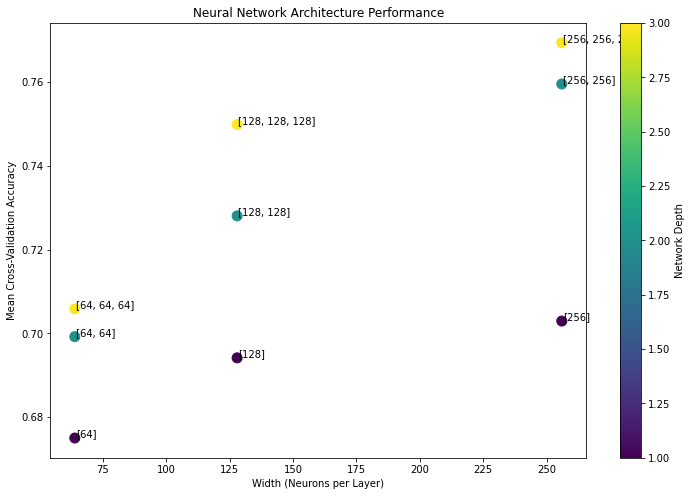

In [42]:
# Plotting
plt.figure(figsize=(12, 8))

plt.scatter(width, cross_validation_accuracies, c=depth, cmap='viridis', s=100)

# Add labels and colorbar
plt.colorbar(label='Network Depth')
plt.xlabel('Width (Neurons per Layer)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Neural Network Architecture Performance')

# Add annotations
for i in range(9):
    plt.annotate(architectures[i], 
                 (width[i], cross_validation_accuracies[i]),
                 xytext=(1, 1), textcoords='offset points')

plt.show()

5. Select the optimal combination for the depth and width. State the rationale for your selection.

In [48]:
optimal_combination = "[depth=3, width=256]"
reason = "This combination has the highest mean cross-validation accuracy on the validation set. Width=256 allows the network to learn more features of the dataset and therefore performs better. Depth=3 allows the network to learn more abstract representation as there are more layers to build upon features learnt from previous layers."

6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


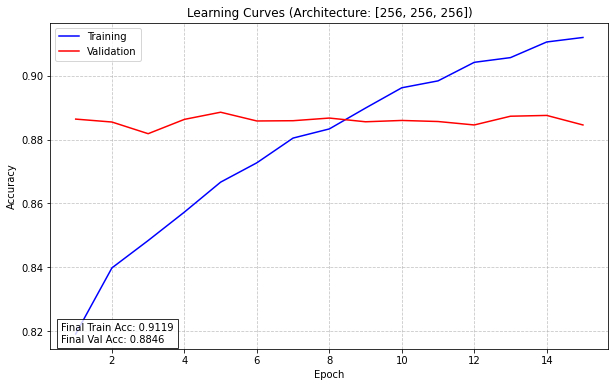

In [89]:
def plot_learning_curves(X_train, y_train, batch_size, best_architecture):

    
    # Train model with optimal architecture
    model = FlexibleMLP(input_size=X_train.shape[1], 
                        hidden_sizes=best_architecture, 
                        output_size=1)
    
    # Get cross-validation folds
    X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict = generate_cv_folds({}, X_train, y_train)
    
    # Train and collect metrics for each fold
    all_train_accuracies = []
    all_test_accuracies = []
    
    for fold in range(5):
        train_accuracies, _, test_accuracies, _, _ = train(
            model,
            X_train_scaled_dict[fold],
            y_train_dict[fold],
            X_val_scaled_dict[fold],
            y_val_dict[fold],
            batch_size
        )
        all_train_accuracies.append(train_accuracies)
        all_test_accuracies.append(test_accuracies)
    
    # Convert to numpy arrays for easier manipulation
    all_train_accuracies = np.array(all_train_accuracies)
    all_test_accuracies = np.array(all_test_accuracies)
    
    # Calculate mean accuracy across folds for every epoch
    mean_train_acc = np.mean(all_train_accuracies, axis=0)
    mean_test_acc = np.mean(all_test_accuracies, axis=0)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(mean_train_acc) + 1)
    
    # Plot mean accuracies
    plt.plot(epochs, mean_train_acc, label='Training', color='blue')
    plt.plot(epochs, mean_test_acc, label='Validation', color='red')
    
    
    plt.title(f'Learning Curves (Architecture: {best_architecture})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show final accuracies
    final_train_acc = mean_train_acc[-1]
    final_test_acc = mean_test_acc[-1]
    plt.text(0.02, 0.02, f'Final Train Acc: {final_train_acc:.4f}\nFinal Val Acc: {final_test_acc:.4f}', 
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()
    
    return model


best_architecture = [256, 256, 256]
best_model = plot_learning_curves(X_train.to_numpy(), y_train, batch_size=64, best_architecture=best_architecture)
# Saving Optimal Model State for A4
torch.save(best_model.state_dict(), 'pretrained_MLP.pth')

7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

Optimization Results:
Best architecture: [256, 256, 256]
Best cross-validation accuracy: 0.5144
[256, 256, 256]


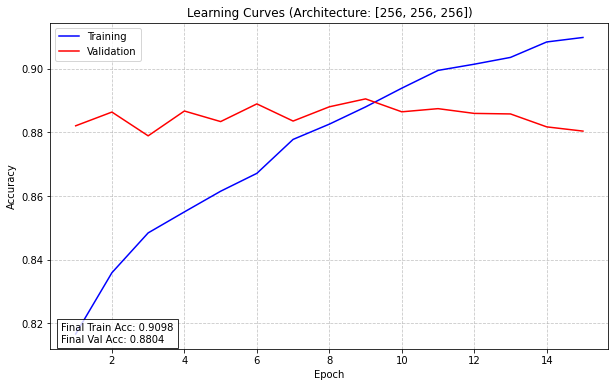

In [75]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import numpy as np
import torch
from torch import nn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

class TorchMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_layers=2, neurons_per_layer=64):
        self.n_layers = n_layers
        self.neurons_per_layer = neurons_per_layer
        
    def _create_model(self):
        hidden_sizes = [self.neurons_per_layer] * self.n_layers
        return FlexibleMLP(input_size=self.X_train_.shape[1], 
                          hidden_sizes=hidden_sizes, 
                          output_size=1)
    
    def fit(self, X, y):
        self.X_train_ = torch.FloatTensor(X)
        self.y_train_ = torch.FloatTensor(y).unsqueeze(1)
        
        self.model_ = self._create_model()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.model_.parameters())
        
        self.model_.train()
        for _ in range(10):  # epochs
            optimizer.zero_grad()
            outputs = self.model_(self.X_train_)
            loss = criterion(outputs, self.y_train_)
            loss.backward()
            optimizer.step()
        
        return self
    
    def predict(self, X):
        X_tensor = torch.FloatTensor(X)
        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(X_tensor)
            predictions = (outputs >= 0.5).float().squeeze().numpy()
        return predictions

def find_optimal_hyperparameters(X_train, y_train):
    X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.to_numpy()
    y_train_np = y_train if isinstance(y_train, np.ndarray) else y_train.to_numpy()
    
    mlp = TorchMLPClassifier()
    
    param_space = {
        'n_layers': Integer(1, 3),
        'neurons_per_layer': Categorical([64, 128, 256])
    }
    
    opt = BayesSearchCV(
        mlp,
        param_space,
        n_iter=9,
        cv=5,
        n_jobs=-1,
        random_state=41
    )
    
    opt.fit(X_train_np, y_train_np)
    
    # Extract the best architecture
    best_architecture = [opt.best_params_['neurons_per_layer']] * opt.best_params_['n_layers']
    
    print("Optimization Results:")
    print(f"Best architecture: {best_architecture}")
    print(f"Best cross-validation accuracy: {opt.best_score_:.4f}")
    
    return best_architecture


best_architecture = find_optimal_hyperparameters(X_train, y_train)
print(best_architecture)
best_model = plot_learning_curves(X_train.to_numpy(), y_train, batch_size=64, best_architecture=best_architecture)